# Mexican population in major cities? 

### Import python/pandas tools

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 1000
pd.set_option("display.max_colwidth", None)

### Get data with [census-data-downloader](https://github.com/datadesk/census-data-downloader)

In [4]:
# !censusdatadownloader latino places

In [5]:
# !pip install census-data-downloader

In [6]:
# !censusdatadownloader latino states

### Read data and define types

In [7]:
src = pd.read_csv(
    "processed/acs5_2019_latino_states.csv",
    low_memory=False,
    dtype={
        "universe": int,
        "mexican": int,
        "mexican_moe": int,
        "hispanic_or_latino": int,
        "geoid": str,
    },
)

### Limit the dataframe to (renamed) columns we need

In [8]:
df = (
    src[src["universe"] > 500000][
        ["geoid", "name", "universe", "hispanic_or_latino", "mexican"]
    ]
    .reset_index(drop=True)
    .copy()
    .rename(
        columns={
            "universe": "all_pop",
            "mexican": "mexican_pop",
            "hispanic_or_latino": "hisp_pop",
        }
    )
)

### Get population shares

In [9]:
df["hisp_pct_pop"] = ((df["hisp_pop"] / df["all_pop"]) * 100).round(2)
df["mex_pct_all_pop"] = ((df["mexican_pop"] / df["all_pop"]) * 100).round(2)
df["mex_pct_hisp_pop"] = ((df["mexican_pop"] / df["hisp_pop"]) * 100).round(2)

### Clean up place names

In [10]:
df["name"] = (
    df["name"]
    .str.replace(" municipality", "", regex=False)
    .str.replace(" city", "", regex=False)
    .str.replace(" zona urbana", "", regex=False)
    .str.replace(" (balance)", "", regex=False)
    .str.replace(" County metro government", "", regex=False)
    .str.replace(" metropolitan government", "", regex=False)
)

### Just one place

In [11]:
df[df["geoid"] == "06"]

,geoid,name,all_pop,hisp_pop,mexican_pop,hisp_pct_pop,mex_pct_all_pop,mex_pct_hisp_pop
4,06,California,39283497,15327688,12687312,39.02,32.3,82.77


### Places with highest share of population as Mexican

In [12]:
df.sort_values("mex_pct_all_pop", ascending=False).head()

,geoid,name,all_pop,hisp_pop,mexican_pop,hisp_pct_pop,mex_pct_all_pop,mex_pct_hisp_pop
43,48,Texas,28260856,11116881,9502159,39.34,33.62,85.48
4,06,California,39283497,15327688,12687312,39.02,32.30,82.77
31,35,New Mexico,2092454,1020817,655160,48.79,31.31,64.18
2,04,Arizona,7050299,2208663,1957968,31.33,27.77,88.65
28,32,Nevada,2972382,853041,643198,28.70,21.64,75.40


### Export dataframe

In [13]:
df.to_csv("output/mexican_pop_states.csv", index=False)

---

### Read geography file for places

In [14]:
gdf_poly = gpd.read_file(
    "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
)

In [15]:
gdf_poly.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Convert polygons to points

In [16]:
gdf_poly = gdf_poly.to_crs("ESRI:102008")

In [17]:
gdf_points = gdf_poly.copy()

In [18]:
gdf_points["geometry"] = gdf_points["geometry"].centroid

### Clean up column names

In [19]:
gdf_points.columns = gdf_points.columns.str.lower()

In [20]:
gdf_points.head()

,id,name,density,geometry
0,01,Alabama,94.650,POINT (817707.727 -806908.935)
1,02,Alaska,1.264,POINT (-2731552.814 3579656.886)
2,04,Arizona,57.050,POINT (-1363318.591 -558633.562)
3,05,Arkansas,56.430,POINT (308210.284 -593478.999)
4,06,California,241.700,POINT (-1948054.320 -87693.537)


In [21]:
geodf = gdf_points[["id", "geometry"]].copy()

---

### Merge 'em

In [22]:
merged_geo = pd.merge(geodf, df, left_on="id", right_on="geoid")

In [23]:
merged_geo.head()

,id,geometry,geoid,name,all_pop,hisp_pop,mexican_pop,hisp_pct_pop,mex_pct_all_pop,mex_pct_hisp_pop
0,01,POINT (817707.727 -806908.935),01,Alabama,4876250,208626,126071,4.28,2.59,60.43
1,02,POINT (-2731552.814 3579656.886),02,Alaska,737068,51870,28205,7.04,3.83,54.38
2,04,POINT (-1363318.591 -558633.562),04,Arizona,7050299,2208663,1957968,31.33,27.77,88.65
3,05,POINT (308210.284 -593478.999),05,Arkansas,2999370,224130,161614,7.47,5.39,72.11
4,06,POINT (-1948054.320 -87693.537),06,California,39283497,15327688,12687312,39.02,32.30,82.77


<AxesSubplot:>

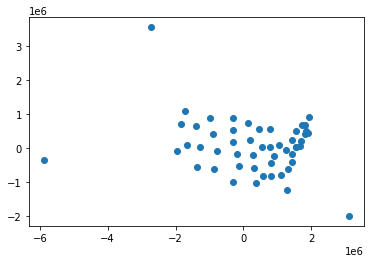

In [24]:
merged_geo.plot()

### Get AP states

In [25]:
ap_states = pd.read_csv("raw/ap_states.csv")

In [26]:
ap_states.head()

,name,usps,ap
0,Alabama,AL,Ala.
1,Alaska,AK,Alaska
2,Arizona,AZ,Ariz.
3,Arkansas,AR,Ark.
4,California,CA,Calif.


### Map AP names to our geodataframe

In [27]:
merged_geo["ap_name"] = merged_geo["name"].map(ap_states.set_index("name").ap)

### Back to GeoJSON projection

In [28]:
merged_geo = merged_geo.to_crs("epsg:4326")

### Centroids, if we need them

In [29]:
merged_geo["lon"] = merged_geo.geometry.apply(lambda p: p.x)
merged_geo["lat"] = merged_geo.geometry.apply(lambda p: p.y)

### Export geo file

In [30]:
merged_geo.to_file("output/large_places_hispanic_pop.geojson", driver="GeoJSON")

### All caps name field for Datawrapper

In [31]:
merged_geo["name_merge"] = merged_geo["name"]

In [32]:
merged_geo[
    [
        "geoid",
        "name",
        "name_merge",
        "ap_name",
        "all_pop",
        "hisp_pop",
        "mexican_pop",
        "hisp_pct_pop",
        "mex_pct_all_pop",
        "mex_pct_hisp_pop",
        "lon",
        "lat",
    ]
].to_csv("output/mexican_pop_states_datawrapper.csv", index=False)